In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad


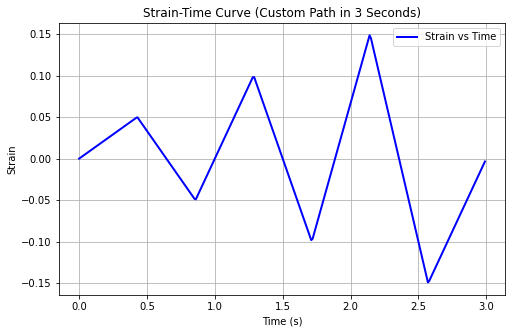

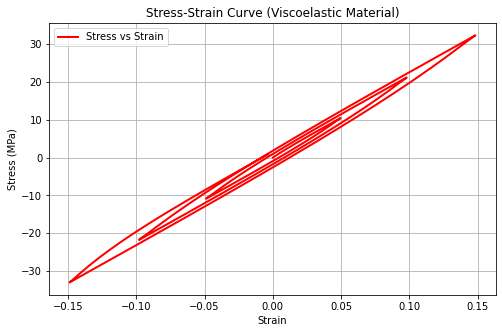

In [3]:
# Synthetic Data Generation from Part 1
def generate_synthetic_data():
    # Parameters for the viscoelastic model
    A = 200  # Elastic stiffness matrix in MPa
    Q = 10   # Kernel decay rate
    D = 50   # Damping coefficient in MPa·s
    dt = 0.01  # Time step

    total_time = 3  
    time = np.arange(0, total_time, dt)  
    custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]
    custom_time_points = np.linspace(0, total_time, len(custom_strain_points))

    # Interpolate to create the strain path
    strain = np.interp(time, custom_time_points, custom_strain_points)

    # Strain rate (dE/dt) using numerical differentiation
    strain_rate = np.gradient(strain, dt)

    stress = np.zeros_like(time)

    # Compute stress using the convolution integral
    for i in range(1, len(time)):
        elastic_stress = A * strain[i]
        viscoelastic_stress = 0
        for j in range(i):
            kernel = np.exp(-Q * (time[i] - time[j]))  # Decaying kernel
            viscoelastic_stress += kernel * D * strain_rate[j] * dt  # Convolution for viscoelastic contribution
        stress[i] = elastic_stress + viscoelastic_stress

    # Convert to torch tensors for training
    strain_tensor = torch.tensor(strain, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
    stress_tensor = torch.tensor(stress, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
    
    return strain_tensor, stress_tensor, time, strain, stress

# Generate the data
strain_tensor, stress_tensor, time, strain, stress = generate_synthetic_data()

# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time", color='b', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Custom Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color='r', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Viscoelastic Material)")
plt.grid(True)
plt.legend()
plt.show()

# Create dataset and dataloader
dataset = TensorDataset(strain_tensor, stress_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
import torch
import torch.nn as nn

# Custom SoftplusSquared activation function
class SoftplusSquared(nn.Module):
    def forward(self, x):
        return torch.nn.functional.softplus(x).pow(2)

# Define the neural network for N_theta(E)
class N_theta(nn.Module):
    def __init__(self):
        super(N_theta, self).__init__()
        
        # Define a fully connected neural network (Elastic density function)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),        # Input layer: 1 input (E), 64 output
            SoftplusSquared(),       # Custom activation function
            nn.Linear(64, 64),       # Hidden layer: 64 input, 64 output
            SoftplusSquared(),       # Custom activation function
            nn.Linear(64, 1)         # Output layer: scalar output (elastic density)
        )
    
    def forward(self, E):
        return self.fc(E)

# Define the function W_theta(E) based on N_theta(E) and its derivative
class W_theta(nn.Module):
    def __init__(self):
        super(W_theta, self).__init__()
        
        # Instantiate the neural network N_theta(E)
        self.N_theta = N_theta()
    
    def forward(self, E):
        # Forward pass through the neural network N_theta(E)
        N_E = self.N_theta(E)
        
        # Compute the gradient of N_theta(E) with respect to E at E = 0
        E_zero = torch.tensor([[0.0]], requires_grad=True)  # Input at E = 0
        N_E_zero = self.N_theta(E_zero)  # Evaluate at E = 0
        
        # Compute the gradient dN_theta/dE at E = 0
        grad_N_E_zero = torch.autograd.grad(N_E_zero, E_zero, create_graph=True)[0]

        # Compute W_theta(E) = N_theta(E) - grad(N_theta)(0) * E
        W_E = N_E - grad_N_E_zero * E
        
        return W_E



# Define the neural network M_Phi(delta)
class M_Phi(nn.Module):
    def __init__(self):
        super(M_Phi, self).__init__()
        
        # Define a fully connected neural network
        self.fc = nn.Sequential(
            nn.Linear(1, 64),        # Input layer: 1 input (delta), 64 output
            nn.ReLU(),               # Activation function (convexity)
            nn.Linear(64, 64),       # Hidden layer: 64 input, 64 output
            nn.ReLU(),               # Activation function (convexity)
            nn.Linear(64, 1)         # Output layer: scalar output
        )
    
    def forward(self, delta):
        return self.fc(delta)

# Define the function V_Phi(E, alpha) based on M_Phi(delta) and its derivative
class V_Phi(nn.Module):
    def __init__(self, C1=1.0, C2=1.0):
        super(V_Phi, self).__init__()
        
        # Instantiate the neural network M_Phi(delta)
        self.M_Phi = M_Phi()
        
        # Constants C1 and C2
        self.C1 = C1
        self.C2 = C2
    
    def forward(self, E, alpha):
        # Compute delta = C1 * E + C2 * alpha
        delta = self.C1 * E + self.C2 * alpha
        
        # Forward pass through the neural network M_Phi(delta)
        M_delta = self.M_Phi(delta)
        
        # Compute the gradient of M_Phi(delta) with respect to delta at delta = 0
        delta_zero = torch.tensor([[0.0]], requires_grad=True)  # Input at delta = 0
        M_delta_zero = self.M_Phi(delta_zero)  # Evaluate at delta = 0
        
        # Compute the gradient dM_Phi/d(delta) at delta = 0
        grad_M_delta_zero = torch.autograd.grad(M_delta_zero, delta_zero, create_graph=True)[0]

        # Compute V_Phi(E, alpha) = M_Phi(delta) - grad(M_Phi)(0) * delta
        V_E_alpha = M_delta - grad_M_delta_zero * delta
        
        return V_E_alpha


# Define the neural network D_Gamma(beta, E)
class D_Gamma(nn.Module):
    def __init__(self):
        super(D_Gamma, self).__init__()
        
        # Define a fully connected neural network
        self.fc = nn.Sequential(
            nn.Linear(2, 64),        # Input layer: 2 inputs (beta, E), 64 output
            nn.ReLU(),               # Activation function (convexity)
            nn.Linear(64, 64),       # Hidden layer: 64 input, 64 output
            nn.ReLU(),               # Activation function (convexity)
            nn.Linear(64, 1)         # Output layer: scalar output
        )
    
    def forward(self, beta, E):
        # Concatenate beta and E as input
        input_data = torch.cat([beta, E], dim=1)
        return self.fc(input_data)

# Define the function G_Gamma(beta, E) based on D_Gamma(beta, E) and its derivative
class G_Gamma(nn.Module):
    def __init__(self):
        super(G_Gamma, self).__init__()
        
        # Instantiate the neural network D_Gamma(beta, E)
        self.D_Gamma = D_Gamma()
    
    def forward(self, beta, E):
        # Forward pass through the neural network D_Gamma(beta, E)
        D_beta_E = self.D_Gamma(beta, E)
        
        # Compute the gradient of D_Gamma(beta, E) with respect to beta at beta = 0
        beta_zero = torch.zeros_like(beta, requires_grad=True)  # Input at beta = 0
        D_beta_zero_E = self.D_Gamma(beta_zero, E)  # Evaluate at beta = 0
        
        # Compute the gradient dD_Gamma/d(beta) at beta = 0
        grad_D_beta_zero = torch.autograd.grad(D_beta_zero_E, beta_zero, create_graph=True)[0]

        # Compute G_Gamma(beta, E) = D_Gamma(beta, E) - grad(D_Gamma)(0, E) * beta
        G_beta_E = D_beta_E - grad_D_beta_zero * beta
        
        return G_beta_E


# Define the neural network A_psi(t)
class A_psi(nn.Module):
    def __init__(self):
        super(A_psi, self).__init__()
        
        # Define a fully connected neural network (modeling internal variable evolution)
        self.fc = nn.Sequential(
            nn.Linear(1, 64),        # Input layer: 1 input (time t), 64 output
            nn.ReLU(),               # Activation function
            nn.Linear(64, 64),       # Hidden layer: 64 input, 64 output
            nn.ReLU(),               # Activation function
            nn.Linear(64, 1)         # Output layer: scalar output (internal variable)
        )
    
    def forward(self, t):
        return self.fc(t)

# Define the surrogate model for alpha using the auxiliary NN A_psi
class Alpha_Surrogate(nn.Module):
    def __init__(self):
        super(Alpha_Surrogate, self).__init__()
        
        # Instantiate the neural network A_psi(t)
        self.A_psi = A_psi()
    
    def forward(self, t, t_0):
        # Forward pass through the neural network A_psi at time t and t_0
        A_t = self.A_psi(t)
        A_t_0 = self.A_psi(t_0)
        
        # Compute the surrogate internal variable alpha_psi(t)
        alpha_psi = A_t - A_t_0
        
        return alpha_psi
    
    
    import torch
import torch.nn as nn

# Assuming W_theta, V_Phi, and Alpha_Surrogate classes are already implemented

class StressModelWithAlphaSurrogate(nn.Module):
    def __init__(self, W_theta, V_Phi, alpha_surrogate):
        super(StressModelWithAlphaSurrogate, self).__init__()
        
        # Elastic potential model W_{Theta}(E)
        self.W_theta = W_theta
        
        # Viscoelastic potential model V_{Phi}(E, alpha)
        self.V_Phi = V_Phi
        
        # Surrogate model for alpha
        self.alpha_surrogate = alpha_surrogate
    
    def forward(self, E, t, t_0):
        # Compute the internal variable alpha using the surrogate model
        alpha_psi = self.alpha_surrogate(t, t_0)
        
        # Compute W_theta(E)
        W_E = self.W_theta(E)
        
        # Compute V_Phi(E, alpha_psi)
        V_E_alpha = self.V_Phi(E, alpha_psi)
        
        # Compute the derivative of W_theta with respect to E (W_theta'(E))
        grad_W_E = torch.autograd.grad(W_E, E, create_graph=True)[0]
        
        # Compute the derivative of V_Phi with respect to E (V_Phi'(E, alpha))
        grad_V_E_alpha = torch.autograd.grad(V_E_alpha, E, create_graph=True)[0]
        
        # Total stress is the sum of both derivatives
        stress = grad_W_E + grad_V_E_alpha
        
        return stress



In [13]:
# Instantiate the models
w_net = WNet()
v_net = VNet()
g_net = GNet()
alpha_net = SurrogateAlpha()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(w_net.parameters()) + list(v_net.parameters()) + list(g_net.parameters()) + list(alpha_net.parameters()), lr=0.001)

    
    # Training loop
num_epochs = 100  # Define how many epochs you want to train for
for epoch in range(num_epochs):
    total_loss = 0
    for strain_batch, stress_batch in data_loader:
        optimizer.zero_grad()

        # Set requires_grad=True for the strain batch to compute gradients
        strain_batch = strain_batch.clone().detach().requires_grad_(True)

        # Forward pass through WNet (Elastic Potential)
        W_E = w_net(strain_batch)
        
        # Compute the gradient of W_E wrt strain_batch for residual stress calculation
        W_sum = W_E.sum()  # Summing W to get a scalar
        grad_W_E = torch.autograd.grad(W_sum, strain_batch, create_graph=True)[0]

        # Step (b): Compute residual stress, interpreted as the viscous component
        S_residual = stress_batch - grad_W_E  # Residual stress = total stress - elastic stress

        # Surrogate model for alpha evolution
        t = torch.linspace(0, 3, strain_batch.size(0)).unsqueeze(1)  # Ensure correct shape for time
        alpha_t = alpha_net(t)

        # Compute V(Phi) (Viscoelastic Potential)
        V_E_alpha = v_net(strain_batch, alpha_t)
        
        # Compute the gradient of V_E_alpha wrt alpha_t for beta (Internal stress evolution)
        V_sum = V_E_alpha.sum()  # Summing V_E_alpha to get a scalar
        grad_V_E_alpha = torch.autograd.grad(V_sum, alpha_t, create_graph=True)[0]
        beta = -grad_V_E_alpha  # Beta is the negative gradient of V wrt alpha_t

        # Compute G(beta, strain) (Dissipation Potential)
        G_beta_E = g_net(beta.detach(), strain_batch)  # Detach beta to avoid second-order gradients

        # Compute the time derivative of alpha (penalty term calculation)
        alpha_sum = alpha_t.sum()  # Summing alpha_t to get a scalar
        alpha_dot = torch.autograd.grad(alpha_sum, t, create_graph=True)[0]
        
        # Compute the penalty term for the internal evolution (Eq from Part 5)
        # The penalty term forces the time evolution of alpha to follow the dissipation potential
        penalty_term = torch.square(alpha_dot - G_beta_E).sum()

        # Loss calculation: Fitting W_E + V_E_alpha to the stress and adding the penalty term
        loss = criterion(W_E + V_E_alpha, stress_batch) + penalty_term

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print loss for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}")






RuntimeError: grad can be implicitly created only for scalar outputs

In [5]:
# Define the augmented loss function with penalty
def augmented_loss(predicted_stress, true_stress, alpha_surrogate, alpha_evolution, lambda_penalty=0.1):
    mse_loss = nn.MSELoss()(predicted_stress, true_stress)
    penalty_loss = lambda_penalty * torch.mean((alpha_surrogate - alpha_evolution) ** 2)
    total_loss = mse_loss + penalty_loss
    return total_loss

# Instantiate the models
W_model = PotentialW()
V_model = PotentialV()
G_model = PotentialG()
alpha_surrogate = AlphaSurrogate()

# Instantiate the viscoelastic model with the alpha surrogate
viscoelastic_model = ViscoelasticModelWithAlpha(W_model, V_model, G_model, alpha_surrogate)

# Define the optimizer
optimizer = optim.Adam(viscoelastic_model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    # Loop through the data loader batches
    for batch_idx, (strain_batch, true_stress_batch) in enumerate(data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Ensure strain_batch requires grad for computing potentials W, V, and G
        strain_batch.requires_grad_(True)

        # Initialize alpha with requires_grad=True so we can compute gradients for alpha evolution
        alpha = torch.zeros_like(strain_batch, requires_grad=True)

        # Forward pass: compute predicted stress, alpha evolution, and surrogate alpha
        predicted_stress, alpha_evolution, alpha_surrogate_output = viscoelastic_model(strain_batch, alpha)

        # Compute the augmented loss (MSE + penalty for alpha evolution)
        loss = augmented_loss(predicted_stress, true_stress_batch, alpha_surrogate_output, alpha_evolution)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print loss for monitoring every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')



Epoch 0/5000, Loss: 171.53121948242188
Epoch 100/5000, Loss: 1.6050570011138916
Epoch 200/5000, Loss: 1.7122862339019775
Epoch 300/5000, Loss: 1.842771291732788
Epoch 400/5000, Loss: 1.1639318466186523
Epoch 500/5000, Loss: 2.418952703475952
Epoch 600/5000, Loss: 2.540087938308716
Epoch 700/5000, Loss: 1.6958011388778687
Epoch 800/5000, Loss: 2.1045618057250977
Epoch 900/5000, Loss: 1.6141386032104492
Epoch 1000/5000, Loss: 1.2885619401931763
Epoch 1100/5000, Loss: 2.257587432861328
Epoch 1200/5000, Loss: 2.393923282623291
Epoch 1300/5000, Loss: 2.1566474437713623
Epoch 1400/5000, Loss: 1.590948462486267
Epoch 1500/5000, Loss: 1.0066596269607544
Epoch 1600/5000, Loss: 1.5094548463821411
Epoch 1700/5000, Loss: 2.462404251098633
Epoch 1800/5000, Loss: 2.102341413497925
Epoch 1900/5000, Loss: 2.455697536468506
Epoch 2000/5000, Loss: 1.4351575374603271
Epoch 2100/5000, Loss: 3.547536849975586
Epoch 2200/5000, Loss: 1.7043272256851196
Epoch 2300/5000, Loss: 1.9841591119766235
Epoch 2400/500

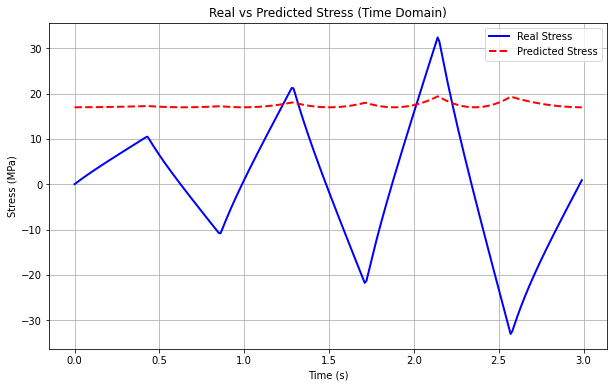

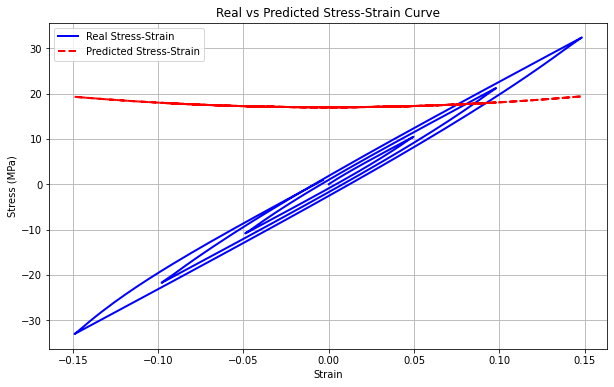

: 

In [6]:
# Evaluate the model and compare with real stress
viscoelastic_model.eval()

# Forward pass to get predictions on the full dataset
with torch.no_grad():
    # Initialize alpha for inference without requires_grad=True
    alpha = torch.zeros_like(strain_tensor)

    # Forward pass through the model to get predictions without computing gradients
    predicted_stress_list = []

    # Iterate over each strain value in the dataset
    for i in range(len(strain_tensor)):
        strain = strain_tensor[i].unsqueeze(0)  # Shape (1, 1)
        alpha_i = alpha[i].unsqueeze(0)  # Shape (1, 1)

        # Use the model to compute stress using the learned potentials without needing gradients
        W_output = W_model(strain)
        V_output = V_model(strain, alpha_i)

        # Here we directly use the outputs from W_model and V_model as stress approximation
        total_stress = W_output + V_output

        # Collect the predicted stress
        predicted_stress_list.append(total_stress.item())

    # Convert the list of predicted stresses to a numpy array for plotting
    predicted_stress = np.array(predicted_stress_list)

# Convert strain and stress to numpy arrays for easier plotting
strain_np = strain_tensor.squeeze().numpy()  # Shape (N,)
stress_np = stress_tensor.squeeze().numpy()  # Shape (N,)

# Plot the real vs predicted stress vs time
plt.figure(figsize=(10, 6))
plt.plot(time, stress_np, label="Real Stress", color='b', linewidth=2)
plt.plot(time, predicted_stress, label="Predicted Stress", color='r', linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress (Time Domain)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the real vs predicted stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(strain_np, stress_np, label="Real Stress-Strain", color='b', linewidth=2)
plt.plot(strain_np, predicted_stress, label="Predicted Stress-Strain", color='r', linestyle='--', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress-Strain Curve")
plt.legend()
plt.grid(True)
plt.show()


Epoch 0/1500, Loss: 2.5959086418151855
Epoch 50/1500, Loss: 2.170762300491333
Epoch 100/1500, Loss: 1.850574016571045
Epoch 150/1500, Loss: 0.9638089537620544
Epoch 200/1500, Loss: 0.5582571625709534
Epoch 250/1500, Loss: 0.4445176422595978
Epoch 300/1500, Loss: 0.3012750744819641
Epoch 350/1500, Loss: 0.11144378036260605
Epoch 400/1500, Loss: 0.05938580259680748
Epoch 450/1500, Loss: 0.043301936239004135
Epoch 500/1500, Loss: 0.03622036427259445
Epoch 550/1500, Loss: 0.03244311362504959
Epoch 600/1500, Loss: 0.030496099963784218
Epoch 650/1500, Loss: 0.029381683096289635
Epoch 700/1500, Loss: 0.02856718935072422
Epoch 750/1500, Loss: 0.017511291429400444
Epoch 800/1500, Loss: 0.010344505310058594
Epoch 850/1500, Loss: 0.0067146895453333855
Epoch 900/1500, Loss: 0.0046524363569915295
Epoch 950/1500, Loss: 0.0033575990237295628
Epoch 1000/1500, Loss: 0.002476896159350872
Epoch 1050/1500, Loss: 0.00186428043525666
Epoch 1100/1500, Loss: 0.001437250874005258
Epoch 1150/1500, Loss: 0.00113

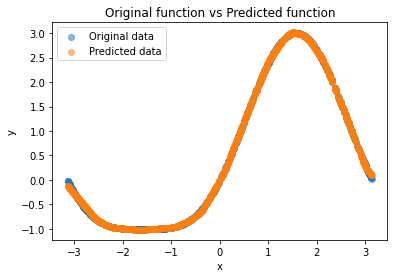

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate data based on the mathematical function
def generate_data(n_samples=1000):
    # Input data is random values between -pi and pi
    x = np.random.uniform(-np.pi, np.pi, n_samples)
    # Output is the composition of functions g(f(x)) = (sin(x))^2 + 2*sin(x)
    y = (np.sin(x))**2 + 2*np.sin(x)
    return x, y

# Define the Inside NN which tries to learn f(x) = sin(x)
class InsideNN(nn.Module):
    def __init__(self):
        super(InsideNN, self).__init__()
        self.layer1 = nn.Linear(1, 8)  # Input size 1, hidden layer size 8
        self.layer2 = nn.Linear(8, 8)  # Second hidden layer size 8
        self.layer3 = nn.Linear(8, 1)  # Output size 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # No activation for the final layer
        return x

# Define the Outside NN which tries to learn g(y) = y^2 + 2*y
class OutsideNN(nn.Module):
    def __init__(self):
        super(OutsideNN, self).__init__()
        self.layer1 = nn.Linear(1, 8)  # Input size 1 (from inside NN), hidden layer size 8
        self.layer2 = nn.Linear(8, 8)  # Second hidden layer size 8
        self.layer3 = nn.Linear(8, 1)  # Output size 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # No activation for the final layer
        return x

# Define the combined network that uses InsideNN and OutsideNN
class CombinedNN(nn.Module):
    def __init__(self):
        super(CombinedNN, self).__init__()
        self.inside_nn = InsideNN()
        self.outside_nn = OutsideNN()

    def forward(self, x):
        # Pass input through the inside NN
        inner_output = self.inside_nn(x)
        # Use the output of inside NN as input to the outside NN
        outer_output = self.outside_nn(inner_output)
        return outer_output

# Main function
if __name__ == "__main__":
    # Generate data
    x_data, y_data = generate_data(1000)
    x_data = torch.tensor(x_data, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)
    y_data = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

    # Instantiate the combined model
    model = CombinedNN()

    # Define a loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 1500
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_data)

        # Compute loss
        loss = criterion(outputs, y_data)

        # Backward pass (gradients flow through both NNs)
        loss.backward()

        # Update weights
        optimizer.step()

        if epoch % 50 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

    # Evaluation and plotting results
    model.eval()
    with torch.no_grad():
        predicted = model(x_data).numpy()

    # Plot the original function vs predicted values
    plt.scatter(x_data.numpy(), y_data.numpy(), label="Original data", alpha=0.5)
    plt.scatter(x_data.numpy(), predicted, label="Predicted data", alpha=0.5)
    plt.legend()
    plt.title("Original function vs Predicted function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


Epoch 0/1500, Loss: 4.790719509124756
Epoch 50/1500, Loss: 4.647236347198486
Epoch 100/1500, Loss: 4.304511547088623
Epoch 150/1500, Loss: 2.7625136375427246
Epoch 200/1500, Loss: 1.0199838876724243
Epoch 250/1500, Loss: 0.09585307538509369
Epoch 300/1500, Loss: 0.023996613919734955
Epoch 350/1500, Loss: 0.012604722753167152
Epoch 400/1500, Loss: 0.007308545988053083
Epoch 450/1500, Loss: 0.004473659675568342
Epoch 500/1500, Loss: 0.00294484943151474
Epoch 550/1500, Loss: 0.0022152524907141924
Epoch 600/1500, Loss: 0.0018758312799036503
Epoch 650/1500, Loss: 0.0017018421785905957
Epoch 700/1500, Loss: 0.0015944804763421416
Epoch 750/1500, Loss: 0.0015232324367389083
Epoch 800/1500, Loss: 0.0014683525077998638
Epoch 850/1500, Loss: 0.0014158053090795875
Epoch 900/1500, Loss: 0.0013817836297675967
Epoch 950/1500, Loss: 0.0013426851946860552
Epoch 1000/1500, Loss: 0.0012966410722583532
Epoch 1050/1500, Loss: 0.0012660666834563017
Epoch 1100/1500, Loss: 0.0012365796137601137
Epoch 1150/150

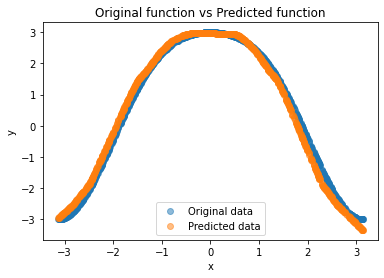

: 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate data
def generate_data(n_samples=1000):
    x = np.random.uniform(-np.pi, np.pi, n_samples)
    y = (np.sin(x))**2 + 3 * np.cos(x)  # Example based on y and derivative of sine (derivative = cos(x))
    return x, y

# Define the Inside NN which tries to learn f(x) = sin(x)
class InsideNN(nn.Module):
    def __init__(self):
        super(InsideNN, self).__init__()
        self.layer1 = nn.Linear(1, 8)  # Input size 1, hidden layer size 8
        self.layer2 = nn.Linear(8, 8)  # Second hidden layer size 8
        self.layer3 = nn.Linear(8, 1)  # Output size 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # No activation for the final layer
        return x

# Define the Outside NN which tries to learn g(y, y') = y^2 + 3y'
class OutsideNN(nn.Module):
    def __init__(self):
        super(OutsideNN, self).__init__()
        self.layer1 = nn.Linear(2, 8)  # Input size 2 (y and y'), hidden layer size 8
        self.layer2 = nn.Linear(8, 8)  # Second hidden layer size 8
        self.layer3 = nn.Linear(8, 1)  # Output size 1
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)  # No activation for the final layer
        return x

# Define the combined network that uses InsideNN and OutsideNN, incorporating differentiation
class CombinedNN(nn.Module):
    def __init__(self):
        super(CombinedNN, self).__init__()
        self.inside_nn = InsideNN()
        self.outside_nn = OutsideNN()

    def forward(self, x):
        # If we're in training mode, we need to calculate the derivative
        if self.training:
            # Enable gradient tracking for the input
            x.requires_grad = True

            # Pass input through the inside NN
            inner_output = self.inside_nn(x)

            # Compute derivative of the inside NN output with respect to the input
            grad_output = torch.autograd.grad(outputs=inner_output, inputs=x,
                                              grad_outputs=torch.ones_like(inner_output),
                                              create_graph=True, retain_graph=True)[0]

            # Concatenate the inner output and its derivative
            combined_input = torch.cat((inner_output, grad_output), dim=1)
        else:
            # In evaluation mode, we do not compute the derivative
            with torch.no_grad():
                inner_output = self.inside_nn(x)
                # Just pass zeros for the derivative in eval mode
                zero_grad_output = torch.zeros_like(inner_output)
                combined_input = torch.cat((inner_output, zero_grad_output), dim=1)

        # Pass the combined input through the outside NN
        outer_output = self.outside_nn(combined_input)
        return outer_output

# Main function
if __name__ == "__main__":
    # Generate data
    x_data, y_data = generate_data(1000)
    x_data = torch.tensor(x_data, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)
    y_data = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

    # Instantiate the combined model
    model = CombinedNN()

    # Define a loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 1500
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_data)

        # Compute loss
        loss = criterion(outputs, y_data)

        # Backward pass (gradients flow through both NNs)
        loss.backward()

        # Update weights
        optimizer.step()

        if epoch % 50 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Evaluation and plotting results
model.eval()
with torch.no_grad():
    predicted = model(x_data).detach().numpy()  # Detach before converting to numpy

# Plot the original function vs predicted values
plt.scatter(x_data.detach().numpy(), y_data.detach().numpy(), label="Original data", alpha=0.5)
plt.scatter(x_data.detach().numpy(), predicted, label="Predicted data", alpha=0.5)
plt.legend()
plt.title("Original function vs Predicted function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
